# Part 2: Predicting prices with Random Forest & Gradient Boosting
***

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import GradientBoostingRegressor
import sklearn

***
## 1. Inputs & EDA

In [25]:
symbol = "GOOG"
df = pd.read_csv("~/Dropbox/Dev/Systrading/Data/{}.csv".format(symbol),
                index_col="date", #index on Dates
                parse_dates = True, #get time index objects
                dayfirst = True,) #AA/MM/DD or DD/MM/AA (International and European format)

In [26]:
df.head(3)

,adjClose,adjHigh,adjLow,adjOpen,adjVolume,close,divCash,high,low,open,splitFactor,volume
date,,,,,,,,,,,,
2014-03-27,558.46,568.00,552.92,568.00,13100,558.46,0,568.00,552.92,568.00,1,13100
2014-03-28,559.99,566.43,558.67,561.20,41100,559.99,0,566.43,558.67,561.20,1,41100
2014-03-31,556.97,567.00,556.93,566.89,10800,556.97,0,567.00,556.93,566.89,1,10800


***
## 2. Feature Engineering

**cf Part 1 for more details on the below**

In [27]:
df['5d_future_close'] = df['adjClose'].shift(-5)
df['5d_close_future_pct'] = df['5d_future_close'].pct_change(5)
df['5d_close_pct'] = df['adjClose'].pct_change(5)

In [28]:
feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14,30,50,200]:

    # Create the moving average indicator and divide by Adj_Close and add it to the datafrane
    df['ma' + str(n)] = talib.SMA(df['adjClose'].values,
                              timeperiod=n) / df['adjClose']
    # Create the RSI indicator and add it to the datafrane
    df['rsi' + str(n)] = talib.RSI(df['adjClose'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

#### Engineering more features: create 2 new volume features, 1-day % change and 5-day SMA of the % change

In [29]:
new_features = ['adjVolume_1d_change', 'adjVolume_1d_change_SMA']
feature_names.extend(new_features)
df['adjVolume_1d_change'] = df['adjVolume'].pct_change()
df['adjVolume_1d_change_SMA'] = talib.SMA(df['adjVolume_1d_change'].values, timeperiod=5)

In [30]:
df = df.dropna()

In [31]:
features = df[feature_names]
targets = df['5d_close_future_pct']
features.head(3)

,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,adjVolume_1d_change,adjVolume_1d_change_SMA
date,,,,,,,,,,,
2015-01-12,-0.041489,1.049719,30.751389,1.056865,37.363452,1.076069,40.743968,1.121577,47.018047,0.129195,0.097507
2015-01-13,-0.011515,1.037910,34.332484,1.046066,38.850271,1.066015,41.572871,1.112729,47.192372,0.019497,0.019847
2015-01-14,-0.000459,1.023953,38.740366,1.034079,40.730669,1.053709,42.630880,1.101749,47.417029,-0.057509,0.065925


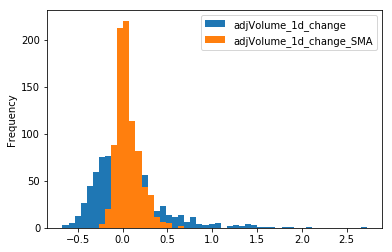

In [32]:
df[new_features].plot(kind='hist', sharex=False, bins=50)
plt.show()

**Plot the correlations between the new features and the targets**

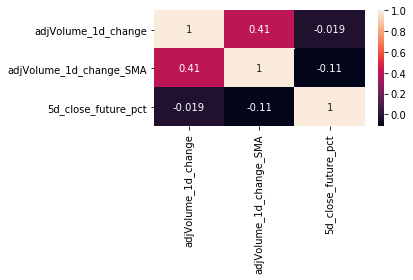

In [33]:
sns.heatmap(df[new_features + ['5d_close_future_pct']].corr(), annot=True)
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical
plt.tight_layout()
plt.show()

***
## 3. Random Forest model

**Train-test split for time-series data** by **manually** creating a size for the training set that is 85% of the total number of samples

In [34]:
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]
features.shape, train_features.shape, test_features.shape

((842, 11), (715, 11), (127, 11))

**Create and fit the random forest model**

In [77]:
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [79]:
# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

**Assess model** - R^2 score and Scatter actuals vs predictions

In [78]:
# Look at the R^2 scores on train and test
rfr.score(train_features, train_targets), rfr.score(test_features, test_targets)

(0.8864908064293745, 0.11096150044403486)

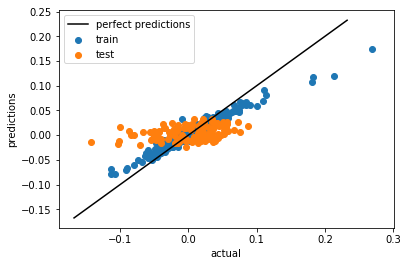

In [80]:
# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets, test_predictions, label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.2), np.arange(xmin, xmax, 0.2), c='k', label='perfect predictions')

plt.xlabel('actual')
plt.ylabel('predictions')
plt.legend()
plt.show()

**Features importances**

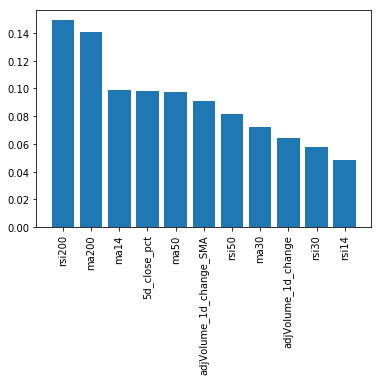

In [81]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

***
## 4. Hyperparameter tuning

In [82]:
# Create a dictionary of hyperparameters to search
grid = {'n_estimators': [200], 'max_depth': [3,4,5], 'max_features': [nb for nb in range(4,12)], 'random_state': [42]}
test_scores = []

In [83]:
# Loop through the parameter grid, set the hyperparameters and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
test_scores[best_idx], ParameterGrid(grid)[best_idx]

(0.10197518615900025,
 {'random_state': 42, 'n_estimators': 200, 'max_features': 7, 'max_depth': 5})

It did not improve our model, let's now try another model...

***
## 5. Gradient Boosting model

**Create and fit the GB model**

In [84]:
gbr = GradientBoostingRegressor(n_estimators=200)
gbr.fit(train_features, train_targets)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

**Assess model** - R^2 score

In [85]:
gbr.score(train_features, train_targets), gbr.score(test_features, test_targets)

(0.8576203807350871, 0.12103326259413538)

**Features importances**

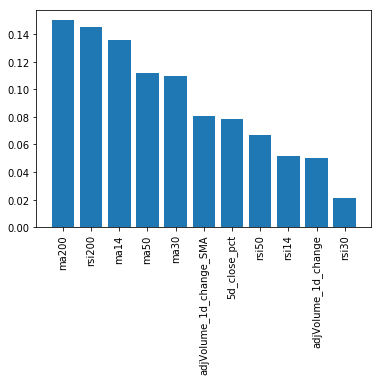

In [86]:
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x = range(features.shape[1])

# Create tick labels 
labels = np.array(feature_names)[sorted_index]

plt.bar(x, feature_importances[sorted_index], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.show()